In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops import math_ops
from common_models import ResNet34, ResNet152
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime, os
plt.style.use('seaborn')
%load_ext tensorboard

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
print('Total Classes:', len(np.unique(np.reshape(y_train, -1))))

Total Classes: 10


In [6]:
features_dict = {
    0: 'airplane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

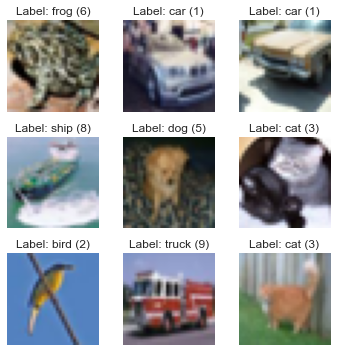

In [7]:
plt.figure(figsize = (5,5))
for i in range(1,10):
    plt.subplot(3,3,i)
    sample_index = np.random.randint(0,x_train.shape[0])
    sample_label = int(y_train[sample_index])
    plt.imshow(x_train[sample_index,:,:,:])
    plt.title(f'Label: {features_dict[sample_label]} ({sample_label})')
    plt.axis(False)
plt.tight_layout()
plt.show()

In [8]:
train_datagen = ImageDataGenerator(
                        rescale = 1./255,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')
train_datagen.fit(x_train)

x_test = x_test/255

###  Lets test the dataset using ResNet
- https://arxiv.org/pdf/1512.03385.pdf

In [9]:
model = ResNet152(n_classes = 10)

In [10]:
log_dir = os.path.join(r'.\logs\scalars',datetime.datetime.now().strftime("%Y%m%d-%H%M")) 

file_writer = tf.summary.create_file_writer(os.path.join(log_dir, 'metrics'))
file_writer.set_as_default()

def lr_scheduler(epoch):
    init_lr = 0.1
    decay_steps = 70
    decay_rate = 0.1
    stepwise = False
    
    p = epoch / decay_steps
    
    if stepwise is True: 
        p = math_ops.floor(p)
    
    lr_exp_decay = math_ops.multiply(init_lr, math_ops.pow(decay_rate, p))
    tf.summary.scalar('learning rate', data=lr_exp_decay, step=epoch)
    return lr_exp_decay
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

optimizer = tf.keras.optimizers.SGD(momentum=0.9,
                                    decay = 0.0001)

model.compile(loss ='sparse_categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])



In [ ]:
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = 256),
                    epochs = 150,
                    validation_data = (x_test, y_test),
                    callbacks = [tensorboard_callback, lr_callback],
                    verbose = 1)
#lr_callback

Train for 196 steps, validate on 10000 samples
Epoch 1/150
196/196 [==============================] - 223s 1s/step - loss: 3.7419 - accuracy: 0.1007 - val_loss: 494707189.5552 - val_accuracy: 0.0999
Epoch 2/150
196/196 [==============================] - 93s 476ms/step - loss: 2.6044 - accuracy: 0.0996 - val_loss: 115.2769 - val_accuracy: 0.1006
Epoch 3/150
196/196 [==============================] - 93s 475ms/step - loss: 2.3737 - accuracy: 0.1003 - val_loss: 3.6282 - val_accuracy: 0.1014
Epoch 4/150
121/196 [=================>............] - ETA: 33s - loss: 2.3208 - accuracy: 0.0996

In [12]:
%tensorboard --logdir logs/scalars --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 1652), started 0:00:58 ago. (Use '!kill 1652' to kill it.)